In [30]:
import math
import os

import cv2
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
from ultralytics import YOLO
import cvzone
from matplotlib import pyplot as plt



In [31]:
# Load the YOLO model
model = YOLO("yolov9t.pt")



In [32]:
coco_names = [
    "person",
    "bicycle",
    "car",
    "motorbike",
    "aeroplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "backpack",
    "umbrella",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "sofa",
    "pottedplant",
    "bed",
    "diningtable",
    "toilet",
    "tvmonitor",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
]

In [33]:
def detect_apple_color(image, x1, y1, x2, y2):
    """
    Determines if the fruit in the bounding box is Red, Green, or Red_and_Green.
    Uses HSV masking and average BGR analysis.
    """
    # Crop the region of interest (ROI)
    roi = image[int(y1):int(y2), int(x1):int(x2)]

    # Convert to HSV for red masking
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Create masks for red color (both ends of the hue spectrum)
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    mask1 = cv2.inRange(hsv_roi, lower_red1, upper_red1)

    lower_red2 = np.array([160, 100, 100])
    upper_red2 = np.array([180, 255, 255])
    mask2 = cv2.inRange(hsv_roi, lower_red2, upper_red2)

    # Combine red masks
    red_mask = mask1 + mask2

    # Find the largest red area
    contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Crop red region inside ROI
        red_region = roi[y:y+h, x:x+w]

        # Calculate average BGR color of the red region
        avg_color = cv2.mean(red_region)[:3]
    else:
        # No red area found, use entire ROI
        avg_color = cv2.mean(roi)[:3]

    b, g, r = avg_color

    # Simple decision logic
    if r > g and r > b:
        return "red"
    elif g > r and g > b:
        return "green"
    else:
        return "red_and_green"

In [34]:
def apple_weight_prediction(height, width, color):
    import scaler_utils_for_apple as su_apple
    min_vals = su_apple.min_vals
    scale_vals = su_apple.scale_vals
    
    scaled_height = (height - min_vals[0]) / scale_vals[0]
    scaled_width = (width - min_vals[1]) / scale_vals[1]
    
    if color == "Red":
        red, green = 1, 0
    elif color == "Green":
        red, green = 0, 1
    else:
        red, green = 0, 0

    apple_info = [scaled_height, scaled_width, red, green]
    
    import joblib
    model = joblib.load("../Trained_model/Weights_Prediction_Apple")
    
    result = model.predict([apple_info])
    return result
    

In [35]:

def detect_banana_color(image, x1, y1, x2, y2):
    """
    Detects the color of a banana in the given bounding box.
    Returns: 'yellow', 'green', or 'yellow_and_green'
    """
    roi = image[int(y1):int(y2), int(x1):int(x2)]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Yellow color range in HSV
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([35, 255, 255])
    yellow_mask = cv2.inRange(hsv_roi, lower_yellow, upper_yellow)

    # Green color range in HSV
    lower_green = np.array([35, 100, 100])
    upper_green = np.array([85, 255, 255])
    green_mask = cv2.inRange(hsv_roi, lower_green, upper_green)

    yellow_pixels = cv2.countNonZero(yellow_mask)
    green_pixels = cv2.countNonZero(green_mask)

    if yellow_pixels > green_pixels and yellow_pixels > 200:
        return "yellow"
    elif green_pixels > yellow_pixels and green_pixels > 200:
        return "green"
    else:
        return "yellow_and_green"



In [36]:
def banana_weight_prediction(height, width, color):
    import scaler_utils_for_banana as su_banana
    min_vals = su_banana.min_vals
    scale_vals = su_banana.scale_vals
    
    scaled_height = (height - min_vals[0]) / scale_vals[0]
    scaled_width = (width - min_vals[1]) / scale_vals[1]
    
    if color == "yellow":
        red, green = 1, 0
    elif color == "Green":
        red, green = 0, 1
    else:
        red, green = 0, 0

    banana_info = [scaled_height, scaled_width, red, green]
    
    import joblib
    model = joblib.load("../Trained_model/Weights_Prediction_Banana")
    
    result = model.predict([banana_info])
    return result



In [37]:

def detect_carrot_color(image, x1, y1, x2, y2):
    """
    Detects the color of a carrot in the given bounding box.
    Returns: 'orange', 'purple', or 'yellow'
    """
    roi = image[int(y1):int(y2), int(x1):int(x2)]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Orange color range
    lower_orange = np.array([10, 100, 100])
    upper_orange = np.array([25, 255, 255])
    orange_mask = cv2.inRange(hsv_roi, lower_orange, upper_orange)

    # Purple color range (HSV for dark magenta)
    lower_purple = np.array([130, 50, 50])
    upper_purple = np.array([160, 255, 255])
    purple_mask = cv2.inRange(hsv_roi, lower_purple, upper_purple)

    # Yellow color range
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([35, 255, 255])
    yellow_mask = cv2.inRange(hsv_roi, lower_yellow, upper_yellow)

    orange_pixels = cv2.countNonZero(orange_mask)
    purple_pixels = cv2.countNonZero(purple_mask)
    yellow_pixels = cv2.countNonZero(yellow_mask)

    # Choose the dominant color
    if orange_pixels > purple_pixels and orange_pixels > yellow_pixels and orange_pixels > 150:
        return "orange"
    elif purple_pixels > orange_pixels and purple_pixels > yellow_pixels and purple_pixels > 150:
        return "purple"
    elif yellow_pixels > orange_pixels and yellow_pixels > purple_pixels and yellow_pixels > 150:
        return "yellow"
    else:
        return "undetermined"



In [38]:
def carrot_weight_prediction(height, width, color):
    import scaler_utils_for_carrot as su_carrot
    min_vals = su_carrot.min_vals
    scale_vals = su_carrot.scale_vals
    
    scaled_height = (height - min_vals[0]) / scale_vals[0]
    scaled_width = (width - min_vals[1]) / scale_vals[1]
    
    if color == "orange":
        red, green = 1, 0
    elif color == "purple":
        red, green = 0, 1
    else:
        red, green = 0, 0

    carrot_info = [scaled_height, scaled_width, red, green]
    
    import joblib
    model = joblib.load("../Trained_model/Weights_Prediction_Carrot")
    
    result = model.predict([carrot_info])
    return result

    

In [39]:
def detect_orange_color(image, x1, y1, x2, y2):
    """
    Detects the color of an orange in the given bounding box.
    Returns: 'orange', 'green', or 'orange_and_green'
    """
    roi = image[int(y1):int(y2), int(x1):int(x2)]
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

    # Orange color range
    lower_orange = np.array([10, 100, 100])
    upper_orange = np.array([25, 255, 255])
    orange_mask = cv2.inRange(hsv_roi, lower_orange, upper_orange)

    # Green color range
    lower_green = np.array([35, 100, 100])
    upper_green = np.array([85, 255, 255])
    green_mask = cv2.inRange(hsv_roi, lower_green, upper_green)

    # Count non-zero pixels in masks
    orange_pixels = cv2.countNonZero(orange_mask)
    green_pixels = cv2.countNonZero(green_mask)

    if orange_pixels > green_pixels and orange_pixels > 200:
        return "orange"
    elif green_pixels > orange_pixels and green_pixels > 200:
        return "green"
    else:
        return "orange_and_green"



In [40]:
def orange_weight_prediction(height, width, color):
    import scaler_utils_for_orange as su_orange
    min_vals = su_orange.min_vals
    scale_vals = su_orange.scale_vals
    
    scaled_height = (height - min_vals[0]) / scale_vals[0]
    scaled_width = (width - min_vals[1]) / scale_vals[1]
    
    if color == "orange":
        red, green = 1, 0
    elif color == "green":
        red, green = 0, 1
    else:
        red, green = 0, 0

    orange_info = [scaled_height, scaled_width, red, green]
    
    import joblib
    model = joblib.load("../Trained_model/Weights_Prediction_Orange")
    
    result = model.predict([orange_info])
    return result

    

In [41]:
def Image_Prediction(image):
    image = cv2.resize(image, (640, 640))
    
    sln = 0
    detected_fruits_Sln = [] # to track how may fruits are detected
    detected_classes = [] # to track the name of fruits
    detected_heights = [] # to track heights
    detected_widths = [] # to track widths
    detected_colors = [] # to track colors
    detected_weights = [] # to track weights
    
    def track_info(sln, classes, heights, widths, colors, weights):
        detected_fruits_Sln.append(sln)
        detected_classes.append(classes)
        detected_heights.append(heights)
        detected_widths.append(widths)
        detected_colors.append(colors)
        detected_weights.append(weights)
        

    # display image with prediction
    results = model(image)  # Run the prediction on the image

    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Access the bounding box coordinates directly from the tensor
            x1, y1, x2, y2 = box.xyxy[0][:4]  # Get the first 4 elements from the tensor
            label = int(box.cls[0])  # Get the class label as an integer
            confidence = box.conf[0]  # Confidence score

            if coco_names[label] in ["banana", "apple", "orange", "carrot"]:                
                
                # ➤ Detect fruit color from bounding box region
                if coco_names[label] == "apple":
                    sln += 1
                    height, width = y2-y1, x2-x1
                    color_label = detect_apple_color(image, x1, y1, x2, y2)
                    print(f"Detected Apple, Height: {height}, Width: {width}") # get Height and width
                    print("Detected Apple, Color :", color_label)
                    weight = apple_weight_prediction(height, width, color_label)
                    print(f"Predicted Apple, weight : {weight} \n")
                    # detected_weights.append(weight)
                
                elif coco_names[label] == "banana":
                    height, width = y2-y1, x2-x1
                    color_label = detect_banana_color(image, x1, y1, x2, y2)
                    print(f"Detected Banana, Height: {height}, Width: {width}")
                    print("Detected Banana, Color :", color_label)
                    weight = banana_weight_prediction(height, width, color_label)
                    print(f"Predicted Banana, weight : {weight} \n")
                    # detected_weights.append(weight)
                
                elif coco_names[label] == "carrot":
                    height, width = y2-y1, x2-x1
                    color_label = detect_carrot_color(image, x1, y1, x2, y2)
                    print(f"Detected Carrot, Height: {height}, Width: {width}")
                    print("Detected Carrot, Color :", color_label)
                    weight = carrot_weight_prediction(height, width, color_label)
                    print(f"Predicted Carrot, weight : {weight} \n")
                    # detected_weights.append(weight)
                
                elif coco_names[label] == "orange":
                    height, width = y2-y1, x2-x1
                    color_label = detect_orange_color(image, x1, y1, x2, y2)
                    print(f"Detected Orange, Height: {height}, Width: {width}")
                    print("Detected Orange, Color :", color_label)
                    weight = orange_weight_prediction(height, width, color_label)
                    print(f"Predicted Orange, weight : {weight} \n")
                    # detected_weights.append(weight)
                
                track_info(sln, coco_names[label], height, width, color_label, weight)
                # print(f"<< {coco_names[label]} >>")
                
                
                # Draw rectangle
                cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                cv2.putText(
                    image,
                    f"{coco_names[label]} {confidence:.2f}",
                    (int(x1), int(y1) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    (0, 255, 0),
                    2,
                )
    plt.imshow(
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    )  # Convert BGR to RGB for proper display
    plt.axis("off")  # Remove axis
    plt.show()
    
    print("\n << <> >> \n")
    print(f"Total {sln} number of fruits have detected ")
    print(f"Detected classes are : {detected_classes}")
    print(f"Detected heights are : {detected_heights}")
    print(f"Detected widths are : {detected_widths}")
    print(f"Detected colors are : {detected_colors}")
    print(f"Detected weights are : {detected_weights}")
    print(f"Total weights : {sum(detected_weights)}")
    
    fruits_dict = {
        "Sln" : detected_fruits_Sln,
        "classes" : detected_classes,
        "heights" : detected_heights,
        "widths" : detected_widths,
        "colors" : detected_colors,
        "weights" : detected_weights
    }
    print(fruits_dict)
    
    return sum(detected_weights)



In [42]:
import cv2
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Hide the root Tkinter window
Tk().withdraw()

# Open file dialog
file_path = askopenfilename(
    title="Select an Image File",
    filetypes=[("Image Files", "*.jpg *.jpeg *.png *.bmp")]
)

if file_path:
    image = cv2.imread(file_path)
    # cv2.imshow("Selected Image", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
else:
    print("No file selected.")



0: 640x640 1 banana, 5 apples, 1 orange, 401.9ms
Speed: 16.3ms preprocess, 401.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Detected Banana, Height: 429.26904296875, Width: 292.08929443359375
Detected Banana, Color : yellow
Predicted Banana, weight : [     126.09] 

Detected Apple, Height: 178.89137268066406, Width: 141.0458984375
Detected Apple, Color : red
Predicted Apple, weight : [     112.14] 

Detected Orange, Height: 212.54718017578125, Width: 141.2789306640625
Detected Orange, Color : orange
Predicted Orange, weight : [     162.98] 

Detected Apple, Height: 145.0706787109375, Width: 90.066650390625
Detected Apple, Color : red
Predicted Apple, weight : [     119.22] 

Detected Apple, Height: 169.375244140625, Width: 114.97021484375
Detected Apple, Color : red
Predicted Apple, weight : [     115.33] 

Detected Apple, Height: 126.13720703125, Width: 105.1431884765625
Detected Apple, Color : red
Predicted Apple, weight : [     118.73] 

Detected Apple, Heig

f:\projects\Final_Year_Project\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
f:\projects\Final_Year_Project\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
f:\projects\Final_Year_Project\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
f:\projects\Final_Year_Project\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
f:\projects\Final_Year_Project\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
f:\projects\Final_Year_Project

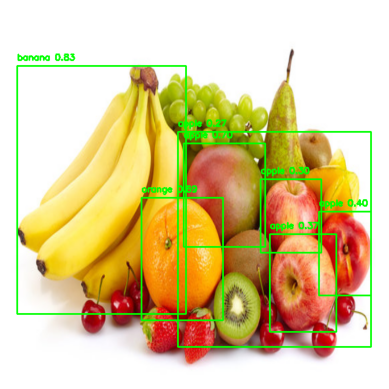


 << <> >> 

Total 5 number of fruits have detected 
Detected classes are : ['banana', 'apple', 'orange', 'apple', 'apple', 'apple', 'apple']
Detected heights are : [tensor(429.2690), tensor(178.8914), tensor(212.5472), tensor(145.0707), tensor(169.3752), tensor(126.1372), tensor(372.3339)]
Detected widths are : [tensor(292.0893), tensor(141.0459), tensor(141.2789), tensor(90.0667), tensor(114.9702), tensor(105.1432), tensor(334.4681)]
Detected colors are : ['yellow', 'red', 'orange', 'red', 'red', 'red', 'red']
Detected weights are : [array([     126.09]), array([     112.14]), array([     162.98]), array([     119.22]), array([     115.33]), array([     118.73]), array([     81.636])]
Total weights : [     836.12]
{'Sln': [0, 1, 1, 2, 3, 4, 5], 'classes': ['banana', 'apple', 'orange', 'apple', 'apple', 'apple', 'apple'], 'heights': [tensor(429.2690), tensor(178.8914), tensor(212.5472), tensor(145.0707), tensor(169.3752), tensor(126.1372), tensor(372.3339)], 'widths': [tensor(292.0893

array([     836.12])

In [43]:
Image_Prediction(image)